# Random Forest - Closed-world Scenario

**최적 Feature 조합**: 영채 (16개 features)
- **성능**: Accuracy 86.24%, F1-Score 86.14%
- **시나리오**: Monitored 사이트 간 분류 (95개 클래스)

## Feature 구성
- **Basic Features (5개)**: 전송 시간, 패킷 간격, 패킷 수, 패킷 비율
- **Burst Features (2개)**: 송수신 버스트 크기
- **Cumulative Features (3개)**: 누적 패킷 수, 최대값
- **Order Skew Features (2개)**: 송수신 순서 왜도
- **First 30 Features (4개)**: 첫 30개 패킷 특성


## 1. 라이브러리 및 데이터 로드


In [1]:
import pandas as pd
import pickle
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')

print("라이브러리 로드 완료")


라이브러리 로드 완료


In [2]:
# Load monitored features
print("Monitored 데이터 로드 중...")
with open('../../content/mon_features.pkl', 'rb') as f:
    mon_features = pickle.load(f)

print(f"데이터 형태: {mon_features.shape}")
print(f"클래스 수: {len(mon_features['website_label'].unique())}")
print(f"샘플 수: {len(mon_features)}")
print("\n데이터 미리보기:")
print(mon_features.head())


Monitored 데이터 로드 중...
데이터 형태: (19000, 19)
클래스 수: 95
샘플 수: 19000

데이터 미리보기:
   total_transmission_time  std_inter_packet_time  avg_outgoing_burst_size  \
0                    10.14               0.041168                 1.551282   
1                    10.16               0.163930                 1.702128   
2                    11.11               0.066661                 1.552632   
3                    13.36               0.047809                 1.525000   
4                    10.64               0.038760                 1.455696   

   avg_incoming_burst_size  num_outgoing_packets  incoming_packet_ratio  \
0                16.666667                 121.0               0.914849   
1                 9.319149                  80.0               0.845560   
2                16.315789                 118.0               0.913108   
3                16.550000                 122.0               0.915629   
4                16.341772                 115.0               0.918208   

   ou

## 2. 최적 Feature 조합 정의 


In [3]:
# 영채의 최적 feature 조합 (16개)
yc_basic = ['total_transmission_time', 'std_inter_packet_time', 
            'num_outgoing_packets', 
            'incoming_packet_ratio', 'outgoing_packet_ratio']
yc_burst = ['avg_outgoing_burst_size', 'avg_incoming_burst_size']
yc_cumul = ['cumul_packets_10pct', 'cumul_packets_30pct', 'cumul_max']
yc_orderskew = ['incoming_order_skew', 'outgoing_order_skew']
yc_first30 = ['outgoing_first_30', 'avg_incoming_order_first_30', 
              'avg_outgoing_order_first_30', 'num_incoming_first_30']

# 최종 feature 조합
selected_features = yc_basic + yc_burst + yc_cumul + yc_orderskew + yc_first30

print(f"선택된 Feature 수: {len(selected_features)}")
print("\nFeature 목록:")
for i, feature in enumerate(selected_features, 1):
    print(f"{i:2d}. {feature}")

print("\nFeature 그룹별 구성:")
print(f"- Basic Features ({len(yc_basic)}개): {yc_basic}")
print(f"- Burst Features ({len(yc_burst)}개): {yc_burst}")
print(f"- Cumulative Features ({len(yc_cumul)}개): {yc_cumul}")
print(f"- Order Skew Features ({len(yc_orderskew)}개): {yc_orderskew}")
print(f"- First 30 Features ({len(yc_first30)}개): {yc_first30}")


선택된 Feature 수: 16

Feature 목록:
 1. total_transmission_time
 2. std_inter_packet_time
 3. num_outgoing_packets
 4. incoming_packet_ratio
 5. outgoing_packet_ratio
 6. avg_outgoing_burst_size
 7. avg_incoming_burst_size
 8. cumul_packets_10pct
 9. cumul_packets_30pct
10. cumul_max
11. incoming_order_skew
12. outgoing_order_skew
13. outgoing_first_30
14. avg_incoming_order_first_30
15. avg_outgoing_order_first_30
16. num_incoming_first_30

Feature 그룹별 구성:
- Basic Features (5개): ['total_transmission_time', 'std_inter_packet_time', 'num_outgoing_packets', 'incoming_packet_ratio', 'outgoing_packet_ratio']
- Burst Features (2개): ['avg_outgoing_burst_size', 'avg_incoming_burst_size']
- Cumulative Features (3개): ['cumul_packets_10pct', 'cumul_packets_30pct', 'cumul_max']
- Order Skew Features (2개): ['incoming_order_skew', 'outgoing_order_skew']
- First 30 Features (4개): ['outgoing_first_30', 'avg_incoming_order_first_30', 'avg_outgoing_order_first_30', 'num_incoming_first_30']


## 3. 데이터 준비


In [4]:
# Closed-world: monitored 사이트만 사용, website_label로 분류
X = mon_features[selected_features]
y = mon_features['website_label'].values

print(f"전체 샘플 수: {X.shape[0]}")
print(f"Feature 수: {X.shape[1]}")
print(f"클래스 수: {len(np.unique(y))}")
print(f"클래스 범위: {min(y)} ~ {max(y)}")

# 클래스별 샘플 수 확인
class_counts = pd.Series(y).value_counts().sort_index()
print(f"\n클래스별 샘플 수 (처음 10개):")
print(class_counts.head(10))
print(f"평균 샘플 수: {class_counts.mean():.1f}")
print(f"표준편차: {class_counts.std():.1f}")

# 데이터 분할 (80% 훈련, 20% 테스트)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n훈련 데이터: {X_train.shape[0]} 샘플")
print(f"테스트 데이터: {X_test.shape[0]} 샘플")
print(f"훈련/테스트 비율: {X_train.shape[0]/X_test.shape[0]:.1f}:1")


전체 샘플 수: 19000
Feature 수: 16
클래스 수: 95
클래스 범위: 0 ~ 94

클래스별 샘플 수 (처음 10개):
0    200
1    200
2    200
3    200
4    200
5    200
6    200
7    200
8    200
9    200
Name: count, dtype: int64
평균 샘플 수: 200.0
표준편차: 0.0

훈련 데이터: 15200 샘플
테스트 데이터: 3800 샘플
훈련/테스트 비율: 4.0:1


## 4. Random Forest 모델 훈련 및 평가


In [5]:
# 최적 하이퍼파라미터 (rf_analysis.ipynb 결과 기반)
best_params = {
    'bootstrap': True, 
    'max_depth': None, 
    'max_features': 'sqrt', 
    'min_samples_leaf': 1, 
    'min_samples_split': 2, 
    'n_estimators': 200
}

print("최적 하이퍼파라미터:")
for param, value in best_params.items():
    print(f"  {param}: {value}")

# Random Forest 모델 훈련
print("\nRandom Forest 모델 훈련 중...")
rf_clf = RandomForestClassifier(
    **best_params,
    random_state=42,
    n_jobs=-1
)

rf_clf.fit(X_train, y_train)
print("모델 훈련 완료!")

# 예측
y_pred = rf_clf.predict(X_test)

# 성능 지표 계산
accuracy = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print("\n" + "="*60)
print("CLOSED-WORLD RANDOM FOREST 결과")
print("="*60)
print(f"정확도 (Accuracy): {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"F1-Score (Macro): {f1_macro:.4f}")
print(f"F1-Score (Weighted): {f1_weighted:.4f}")
print("="*60)


최적 하이퍼파라미터:
  bootstrap: True
  max_depth: None
  max_features: sqrt
  min_samples_leaf: 1
  min_samples_split: 2
  n_estimators: 200

Random Forest 모델 훈련 중...
모델 훈련 완료!

CLOSED-WORLD RANDOM FOREST 결과
정확도 (Accuracy): 0.8624 (86.24%)
F1-Score (Macro): 0.8614
F1-Score (Weighted): 0.8614



Feature 중요도 (상위 10개):
                    feature  importance
       num_outgoing_packets    0.111831
avg_incoming_order_first_30    0.101148
avg_outgoing_order_first_30    0.095505
        outgoing_order_skew    0.077785
        incoming_order_skew    0.073700
    avg_incoming_burst_size    0.072855
      incoming_packet_ratio    0.067498
      outgoing_packet_ratio    0.067204
      std_inter_packet_time    0.064738
    avg_outgoing_burst_size    0.059809


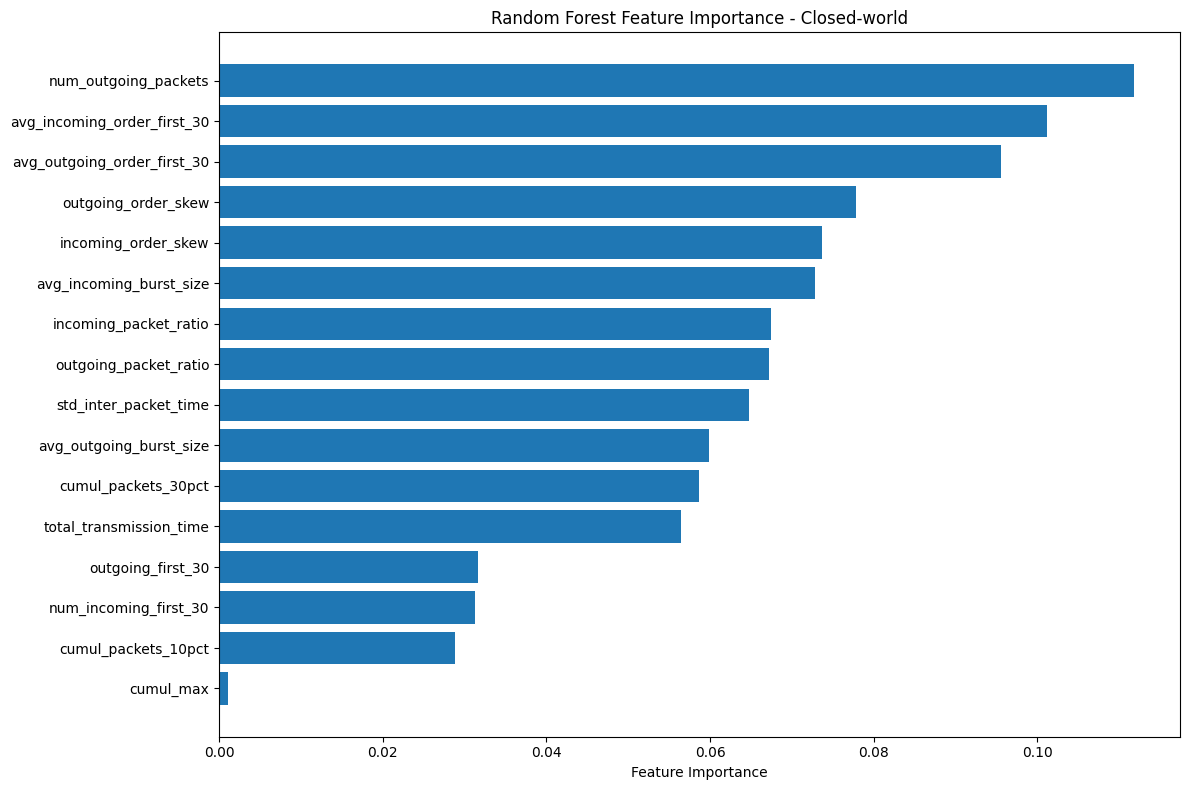

In [6]:
# Feature 중요도 분석
feature_importance = pd.DataFrame({
    'feature': selected_features,
    'importance': rf_clf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature 중요도 (상위 10개):")
print(feature_importance.head(10).to_string(index=False))

# Feature 중요도 시각화
plt.figure(figsize=(12, 8))
plt.barh(range(len(feature_importance)), feature_importance['importance'])
plt.yticks(range(len(feature_importance)), feature_importance['feature'])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance - Closed-world')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
